# Constructing data sets with paired sequence and abundance values

In [1]:
from Bio import SeqIO
import os
import pandas as pd
import pickle as pkl
import glob
import tqdm
import numpy as np
from scipy import stats
import networkx as nx
from pathlib import Path

import matplotlib.pyplot as plt

import numpy as np

import matplotlib
import matplotlib as mpl
import seaborn as sns

from sklearn.cluster import AgglomerativeClustering

# Loading files

abundance and sequence

In [19]:
DIRs_abundance = glob.glob("../../data/PaxDb/paxdb-abundance-files-v5.0/*ho2018*")
sequence= glob.glob("../../data/PaxDb/paxdb-protein-sequences-v5.0/*ho2018*")

In [20]:
DIRs_abundance

['../../data/PaxDb/paxdb-abundance-files-v5.0/ho2018']

In [40]:


def read_paxdb_dataset(path) -> pd.DataFrame:
    dset = pd.read_csv(path, sep = '\t', header=11)
    dset = dset.rename(columns = {'#string_external_id': 'external_id'})
    dset['external_id'] = dset['external_id'].map(str)
    #dset['external_id'] = dset['external_id'].map(lambda s: s.split('.')[1])
    return dset

organism_experiment_dict = {}
for organism_id in os.listdir("../../data/PaxDb/paxdb-abundance-files-v5.0/"):
#organism_id = 'ho2018'
    organism_dir = Path('../../data/PaxDb/paxdb-abundance-files-v5.0') / organism_id

    DIRs_abundance = glob.glob(f"../../data/PaxDb/paxdb-abundance-files-v5.0/*{organism_id}*")
    if len(DIRs_abundance) ==0:
        continue
    organism_dir = Path(DIRs_abundance[0])
    organism_experiment_list = list(map(read_paxdb_dataset, organism_dir.glob('*.txt')))
    if len(organism_experiment_list) > 2:
        organism_experiment_dict[organism_id] = {"experiment_list":organism_experiment_list, "average_pairwise_correlation":0, "median_pairwise_correlation":0,"number_of_experiments":0 }

In [41]:
len(organism_experiment_dict)

64

## Calc pairwise correlation

In [42]:
for item in tqdm.tqdm(organism_experiment_dict.items()):
    organism_id = item[0]

    organism_experiment_list = item[1]["experiment_list"]
    n_entries = len(organism_experiment_list)
   # print(f"working on {organism_id} with {n_entries} entries")
    organisme_experiment_corr_mat = np.zeros((n_entries, n_entries)) #* np.nan
    non_zero = []
    for i in range(n_entries - 1):
        for j in range(i + 1, n_entries):
            match = pd.merge(organism_experiment_list[i], organism_experiment_list[j], on='external_id', suffixes=('_i', '_j'))
            if match.shape[0] > 1000:
                corr, pvalue = stats.pearsonr(match['abundance_i'], match['abundance_j'])
                if pvalue < 0.05:
                    organisme_experiment_corr_mat[i, j] = corr
                    non_zero.append(corr)
    
    if len(non_zero) > 0:
        non_zero = np.array(non_zero)
        organism_experiment_dict[organism_id]["average_pairwise_correlation"] = np.mean(non_zero)
        organism_experiment_dict[organism_id]["median_pairwise_correlation"] = np.median(non_zero)
        organism_experiment_dict[organism_id]["number_of_experiments"] = n_entries

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [02:17<00:00,  2.15s/it]


In [43]:
df_pairwise_corr= {"id":[],"average":[],"median":[],"N_experiments":[]}
for item in organism_experiment_dict.items():
    print(f"{item[0]}: Average pairwise corr { item[1]['average_pairwise_correlation']:.2f} Median pairwise corr {item[1]['median_pairwise_correlation']:.2f} number of experiments {item[1]['number_of_experiments']:.2f}")
    df_pairwise_corr["id"].append(item[0])
    df_pairwise_corr["average"].append(item[1]['average_pairwise_correlation'])
    df_pairwise_corr["median"].append(item[1]['median_pairwise_correlation'])
    df_pairwise_corr["N_experiments"].append(item[1]['number_of_experiments'])

pd.DataFrame(df_pairwise_corr).to_csv("/proj/berzelius-2024-205/sandra/DeepTranslation/result/2024-1001/pairwise_corr.csv")

226186: Average pairwise corr 0.98 Median pairwise corr 0.98 number of experiments 3.00
511145: Average pairwise corr 0.58 Median pairwise corr 0.59 number of experiments 19.00
392499: Average pairwise corr 0.00 Median pairwise corr 0.00 number of experiments 0.00
5691: Average pairwise corr 0.55 Median pairwise corr 0.55 number of experiments 4.00
1286170: Average pairwise corr 1.00 Median pairwise corr 1.00 number of experiments 3.00
6239: Average pairwise corr 0.68 Median pairwise corr 0.70 number of experiments 12.00
257313: Average pairwise corr 0.00 Median pairwise corr 0.00 number of experiments 0.00
83332: Average pairwise corr 0.68 Median pairwise corr 0.65 number of experiments 11.00
353153: Average pairwise corr 0.98 Median pairwise corr 0.99 number of experiments 6.00
1314: Average pairwise corr 0.93 Median pairwise corr 0.93 number of experiments 5.00
4896: Average pairwise corr 0.48 Median pairwise corr 0.55 number of experiments 9.00
192222: Average pairwise corr 0.00 Me

## Construct Aglomerative clusters

In [226]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
   # print(linkage_matrix)

    # Plot the corresponding dendrogram
    plt.figure(figsize=[15,7])
    dendrogram(linkage_matrix, **kwargs)

In [234]:
def calc_pairwise_corr(experiment_list) -> pd.DataFrame:

    n_entries = len(experiment_list)
    paxdb_corr = np.zeros((n_entries, n_entries)) * np.nan

    for i in range(n_entries - 1):
        for j in range(i + 1, n_entries):
            match = pd.merge(experiment_list[i], experiment_list[j], on='external_id', suffixes=('_i', '_j'))
            if match.shape[0] > 1000:
                corr, pvalue = stats.pearsonr(match['abundance_i'], match['abundance_j'])
                if pvalue < 0.05:
                    paxdb_corr[i, j] = corr
    for i in range(n_entries - 1):
        for j in range(i + 1, n_entries):
            paxdb_corr[j,i] = paxdb_corr[i, j]
            
    df = pd.DataFrame(paxdb_corr>=0.8,
                      index=np.arange(paxdb_corr.shape[0]),    # 1st column as index
                      columns=np.arange(paxdb_corr.shape[1]))
    return df

def calc_max_clique(df) -> dict:
    net = nx.from_pandas_adjacency(df)
    l = nx.find_cliques(net)
    max_clique_df = {"size":0,'index':[]}
    for i in l:
        if len(i) > max_clique_df["size"]:
            max_clique_df["size"] = len(i)
            max_clique_df["index"] = i
    return max_clique_df

df = calc_pairwise_corr(organism_experiment_list)#glob.glob('../../data/PaxDb/paxdb-abundance-files-v5.0/ho2018/*'))
clique = calc_max_clique(df)

In [236]:
l = list(organism_dir.glob('*.txt'))
for idx in clique["index"]:
    print(l[idx])

../../data/PaxDb/paxdb-abundance-files-v5.0/ho2018/experiment_NAG.txt
../../data/PaxDb/paxdb-abundance-files-v5.0/ho2018/experiment_THAK.txt
../../data/PaxDb/paxdb-abundance-files-v5.0/ho2018/experiment_DGD.txt
../../data/PaxDb/paxdb-abundance-files-v5.0/ho2018/experiment_LEE2.txt


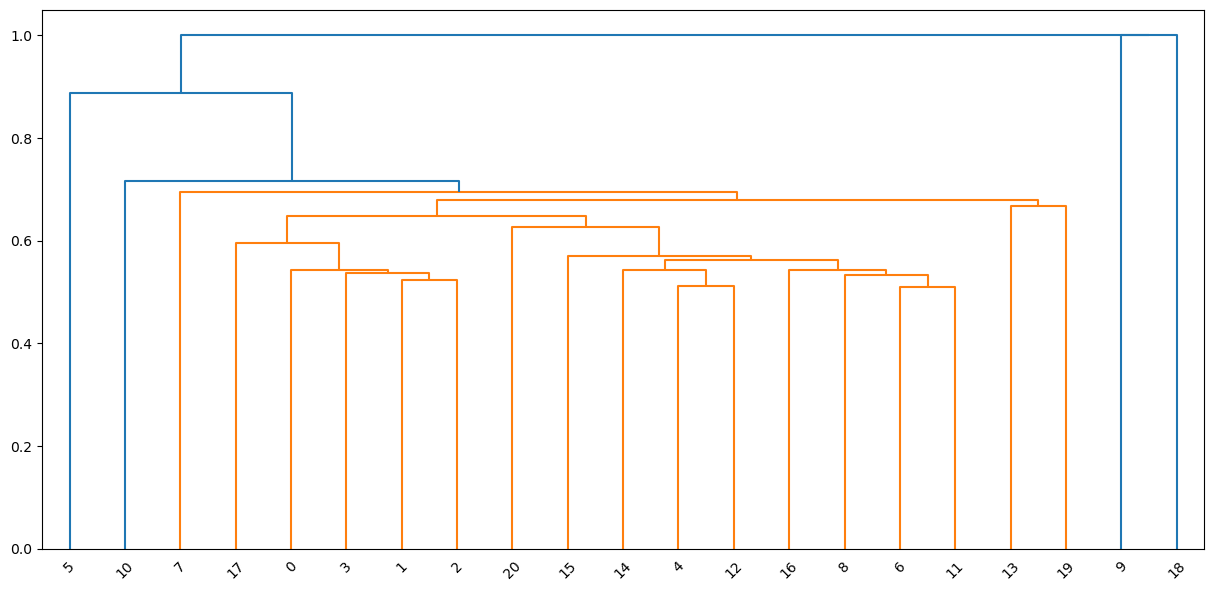

In [227]:
model = AgglomerativeClustering(metric="precomputed", linkage='average', compute_distances=True, distance_threshold=0.0, n_clusters=None)

model.fit(1/(organisme_experiment_corr_mat + 1))
organisme_experiment_corr_mat_hclustered = np.zeros_like(organisme_experiment_corr_mat)

hcluster_idx = model.labels_

for idx_row in range(model.labels_.shape[0]):
    for idx_column in range(model.labels_.shape[0]):
        organisme_experiment_corr_mat_hclustered[idx_row,idx_column] = organisme_experiment_corr_mat[hcluster_idx[idx_row],hcluster_idx[idx_column]]

plot_dendrogram(model)

## Plot Herarchical cluster map

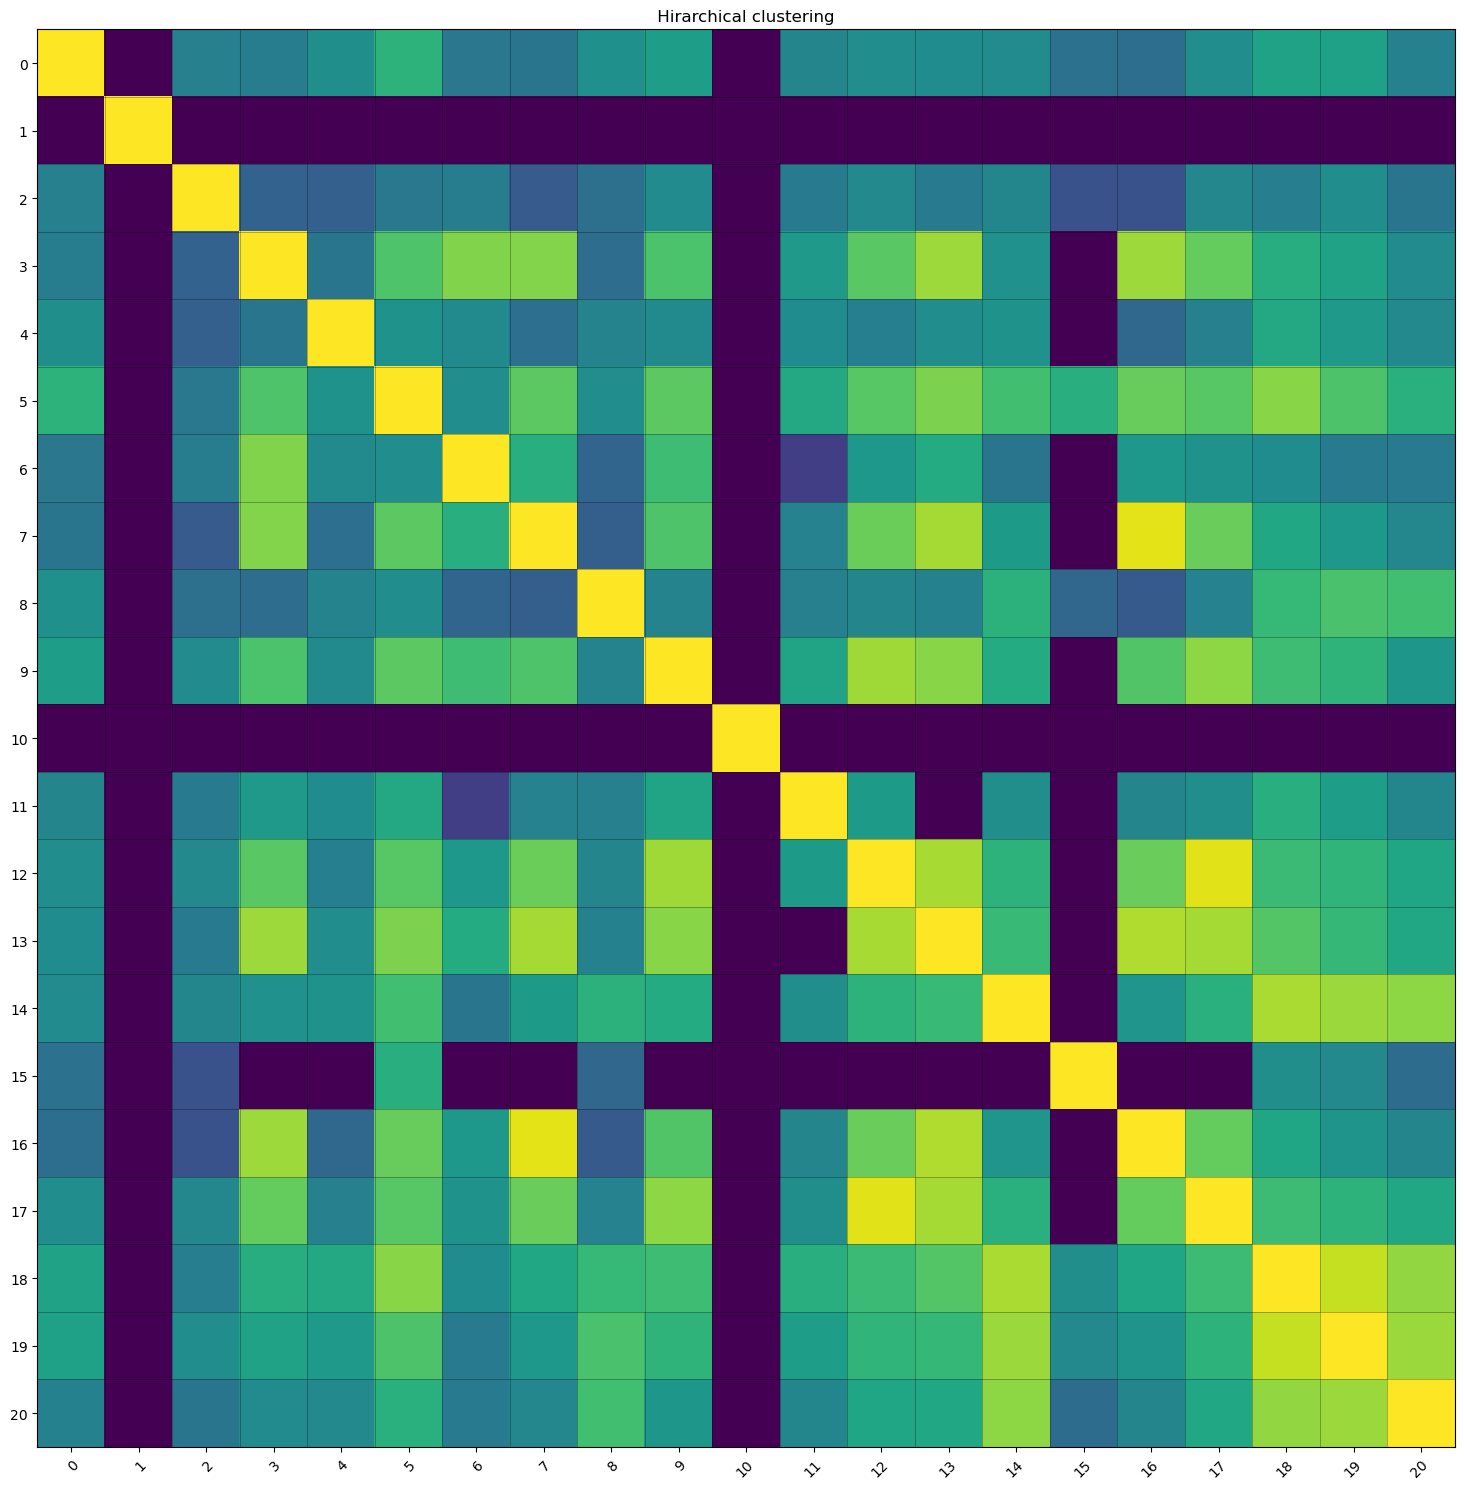

largest clique is:15 with nodes: [13, 148, 50, 178, 216, 125, 218, 145, 238, 68, 120, 69, 71, 162, 191]


In [229]:





harvest = organisme_experiment_corr_mat
vegetables = [f"{idx}" for idx in range(organisme_experiment_corr_mat.shape[0]) ]
farmers = [f"{idx}" for idx in range(organisme_experiment_corr_mat.shape[0]) ]

fig, ax = plt.subplots(figsize=[15,15])


im = ax.imshow( organisme_experiment_corr_mat_hclustered)
#im = ax.imshow(organisme_experiment_corr_mat)



# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(farmers)), labels=farmers)
ax.set_yticks(np.arange(len(vegetables)), labels=vegetables)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

#plt.colorbar()
ax.set_xticks(np.arange(-.5, len(farmers), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(farmers), 1), minor=True)

# Gridlines based on minor ticks
ax.grid(which='minor', color='k', linestyle='-', linewidth=0.5, alpha=0.4)
ax.tick_params(which='minor', bottom=False, left=False)



ax.set_title(" Hirarchical clustering ")
fig.tight_layout()
plt.show()

df = pd.DataFrame(musculus_paxdb_corr>0.8,index=np.arange(musculus_paxdb_corr.shape[0]),    # 1st column as index
columns=np.arange(musculus_paxdb_corr.shape[1]))
net = nx.from_pandas_adjacency(df)
l = nx.find_cliques(net)
max_clique = {"size":0,'index':[]}
for i in l:
    if len(i) > max_clique["size"]:
        max_clique["size"] = len(i)
        max_clique["index"] = i
        
print(f'largest clique is:{max_clique["size"]} with nodes: {max_clique["index"]}')

# Whole organism data

In [23]:
DIRs_abundance = glob.glob("../../data/PaxDb/paxdb-abundance-files-v5.0/*/*WHOLE_ORGANISM*")
sequence= glob.glob("../../data/PaxDb/paxdb-protein-sequences-v5.0/*")

In [247]:
with open("../../data/PaxDb/Paxdb-sequences_processed/8022/embedding.pkl", "br") as f:
    df_embedding = pkl.load(f) 
    df_embedding["Embedding"] = df_embedding["Embedding"][:len(df_embedding["id"])]
df_embedding = pd.DataFrame(df_embedding)

/home/x_sanvi/.conda/envs/jupyter/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [248]:
df_embedding["id"] = df_embedding.apply(lambda x: x["id"].split(".")[1], axis = 1)

In [25]:
list_of_rows = []
for file in DIRs_abundance:

    with open(file, "r") as f:
        string = f.read()
    list_of_rows.append(string.split('\n'))



In [28]:

for rows in list_of_rows:
    for row in rows:
        if "name" in row:
            print(row)
            break

#name: B.thetaiotaomicron VPI-5482 - Whole organism (Integrated)
#name: E.coli - Whole organism (Integrated)
#name: Swittichii RW1 - Whole organism (Integrated)
#name: T.brucei - Whole organism (Integrated)
#name: Rornithinolytica B6 - Whole organism (Integrated)
#name: C.elegans - Whole organism (Integrated)
#name: Bpertussis Tohama I - Whole organism (Integrated)
#name: M.tuberculosis - Whole organism (Integrated)
#name: T.cruzi - Whole organism (Integrated)
#name: S.pyogenes M1GAS - Whole organism (Integrated)
#name: S.pombe - Whole organism (Integrated)
#name: C.jejuni - Whole organism (Integrated)
#name: Kpneumoniae - Whole organism (Integrated)
#name: M.aeruginosa - Whole organism (Integrated)
#name: O.satival - Whole organism (Integrated)
#name: Hvolcanii DS2 - Whole organism (Integrated)
#name: B.subtilis - Whole organism (Integrated)
#name: G.gallus - Whole organism (Integrated)
#name: Mhominis ATCC23114 - Whole organism (Integrated)
#name: R.norvegicus - Whole organism (Integ

# Prepare Ho2018 data

In [97]:
with open("../../data/Ho2018/embedding/scerevisiae_aminoacid_uniprot_20200120.pkl", "br") as f:
    df_embedding = pkl.load(f) 
df_embedding["Embedding"] = df_embedding["Embedding"][:len(df_embedding["id"])]
df_embedding = pd.DataFrame(df_embedding)
df_embedding["id"] = df_embedding.apply(lambda x: x["id"].split('|')[1], axis = 1)
df_abundance = pd.read_csv("../../data/Ho2018/prot_abundance_molecules_per_cell_no_gfp.csv")
df_abundance = df_abundance[["Median_molecules_per_cell", "swissprot_ac"]]
df_abundance.columns = ["Abundance","id"]
df = df_abundance.merge(df_embedding, how="inner", on="id")
df["TM"] = df["Abundance"]

/home/x_sanvi/.conda/envs/jupyter/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [143]:
df_abundance = pd.read_csv("../../data/Ho2018/prot_abundance_molecules_per_cell_no_gfp.csv")

In [102]:
df_experiments_Ho2018 = df_abundance[['LU', 'PENG', 'KUL', 'LAW', 'LAHT', 'DGD',
       'LEE2', 'THAK', 'NAG', 'PIC', 'WEB', 'TKA', 'BRE', 'DEN', 'MAZ', 'CHO',
       'YOF', 'NEW', 'LEE', 'DAV', 'GHA']]

In [156]:
def median_row(row):
    row = np.array(row)
    #print(type(row[0]))
    return np.ceil(np.median(row[~pd.isnull(row)]))

In [157]:
df_abundance["median"]=df_abundance.apply(lambda x: median_row(x[['LU', 'PENG', 'KUL', 'LAW', 'LAHT', 'DGD',
       'LEE2', 'THAK', 'NAG', 'PIC', 'WEB', 'TKA', 'BRE', 'DEN', 'MAZ', 'CHO',
       'YOF', 'NEW', 'LEE', 'DAV', 'GHA']]), axis=1)

In [160]:
df_abundance.loc[~(df_abundance["Median_molecules_per_cell"] == df_abundance["median"])][["Median_molecules_per_cell", "median"]]

,Median_molecules_per_cell,median
43,188.0,189.0
55,216.0,217.0
58,220.0,221.0
73,255.0,256.0
91,289.0,290.0
...,...,...
5357,104294.0,104295.0
5358,106439.0,106440.0
5360,107317.0,107318.0
5366,118983.0,118984.0


In [169]:
experiment_list = ['LU', 'PENG', 'KUL', 'LAW', 'LAHT', 'DGD',
       'LEE2', 'THAK', 'NAG', 'PIC', 'WEB', 'TKA', 'BRE', 'DEN', 'MAZ', 'CHO',
       'YOF', 'NEW', 'LEE', 'DAV', 'GHA']

for experiment in experiment_list:
    file = f"../../data/Ho2018/experiments/experiment_{experiment}.txt" 
    with open(file, "w") as f:
        f.write("\n".join(["#" for _ in range(11)]))
        f.write("\n")
    df_abundance[["swissprot_ac", experiment]].dropna().to_csv(file ,columns=["swissprot_ac", experiment],sep = '\t', mode="a", index=False, header=["#string_external_id",	"abundance"])

# Construct correlated data sets 

In [214]:
import re
import shutil
org = []
with open("../../data/PaxDb/data_sets/fasta_test/log_success.txt", "r") as f:
    organism_logs = f.read()
for log in organism_logs.split('\n')[:-1]:
    organism = log.split()[1]
    org.append(organism)
    #os.mkdir(f"../../data/PaxDb/Paxdb-sequences_processed_subset/{organism}")
    #os.mkdir(f"../../data/PaxDb/Paxdb-sequences_processed_subset/{organism}/experiments")

    for idx, path in enumerate(log.split('PosixPath')[1:]):
        path = re.sub('[(),]', '', path)
        path=path.strip("]")
        path=path.replace("'", "")
        path=path.strip()
        file = path.split("/")[-1]
        #shutil.copy(path, f"../../data/PaxDb/Paxdb-sequences_processed_subset/{organism}/experiments/{file}")
        


In [217]:
for organism in org:
    DIR_source = f"../../data/PaxDb/Paxdb-sequences_processed/{organism}"
    DIR_target = f"../../data/PaxDb/Paxdb-sequences_processed_subset/{organism}"
    shutil.copy(f"{DIR_source}/train.fa", f"{DIR_target}/train.fa")
    shutil.copy(f"{DIR_source}/test.fa", f"{DIR_target}/test.fa")
    shutil.copy(f"{DIR_source}/embedding.pkl", f"{DIR_target}/embedding.pkl")

In [263]:
def read_paxdb_dataset(path) -> pd.DataFrame:
    dset = pd.read_csv(path, sep = '\t', header=11)
    dset = dset.rename(columns = {'#string_external_id': 'id'})
    dset['id'] = dset['id'].map(str)
    dset['id'] = dset['id'].map(lambda s: s.split('.')[1])
    return dset

# Load embeddings
organism = 9606
with open(f"../../data/PaxDb/Paxdb-embedding/{organism}.pkl", "br") as f:
    df_embedding = pkl.load(f)
df_embedding["Embedding"] = df_embedding["Embedding"][:len(df_embedding["id"])]
df_embedding = pd.DataFrame(df_embedding)
df_embedding["id"] = df_embedding.apply(lambda x: x["id"].split(".")[1], axis=1)

# create organ file map


DIRs_abundance = glob.glob(f"../../data/PaxDb/paxdb-abundance-files-v5.0/{organism}/*")
df_organ_file = {}
organs = set()
for file in DIRs_abundance:
    with open(file, "r") as f:
        string = f.read()
        rows = string.split('\n')
    for row in rows:
        if "#organ" in row:
            #print(row)
            organ = row.split()[-1]
            organs.add(organ)
            break
    if organ not in df_organ_file:
        df_organ_file[organ] = [file]
    else:
        df_organ_file[organ].append(file)


/home/x_sanvi/.conda/envs/jupyter/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [304]:
import shutil
import os
organism = 9606
DIR = f"../../data/PaxDb/Paxdb-sequences_processed_Human_cell_line"
for idx, file in enumerate(df_organ_file['CELL_LINE']):
    with open (file, "r") as f:
        line = f.read().split('\n')[1].split(',')
        s = "_".join(l.strip() for l in line[1:])
        cell_line = s.split(" (")[0]

    
    if not os.path.isdir(f"{DIR}/{cell_line}"):
        os.mkdir(f"{DIR}/{cell_line}")
    if not os.path.isdir(f"{DIR}/{cell_line}/experiments"):
        os.mkdir(f"{DIR}/{cell_line}/experiments")
   # for experiment_file in item[1]:
    shutil.copy(file, f"{DIR}/{cell_line}/experiments/{experiment_file.split('/')[-1]}")
    shutil.copy(f"../../data/PaxDb/Paxdb-sequences_processed/{organism}/embedding.pkl", f"{DIR}/{cell_line}/embedding.pkl")
    shutil.copy(f"../../data/PaxDb/Paxdb-sequences_processed/{organism}/train.fa", f"{DIR}/{cell_line}/train.fa")
    shutil.copy(f"../../data/PaxDb/Paxdb-sequences_processed/{organism}/test.fa", f"{DIR}/{cell_line}/test.fa")
    